In [1]:
import pandas as pd
import zipfile
import os

# Step 1 - Set the dataset location
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
extract_path = os.path.join(dataset_path, 'train_extracted')

# Step 2 - Extract
if not os.path.exists(extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Train data extracted successfully.")
else:
    print("Train data already extracted.")

# Step 3 - Find CSVs (even if they are inside subfolders)
csv_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found CSV files: {csv_files}")

# Step 4 - Load CSVs
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')  # tag experiment ID
    dataframes.append(df)

# Step 5 - Concatenate
if dataframes:
    full_train_data = pd.concat(dataframes, ignore_index=True)
    print(f"Total shape of combined train dataset: {full_train_data.shape}")
    print(full_train_data.head())
else:
    print("No CSV files found.")


Train data already extracted.
Found CSV files: ['C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_1.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_20.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_21.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_23.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_24.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_9.csv']
Total shape of combined train dataset: (52940, 4)
        time  input_voltage     el_power experiment
0  810.07028           10.0  1228.791720       ex_1
1  811.06938           10.0  1223.041745       ex_1
2  812.06848           10.0  1244.960866       ex_1
3  813.06758

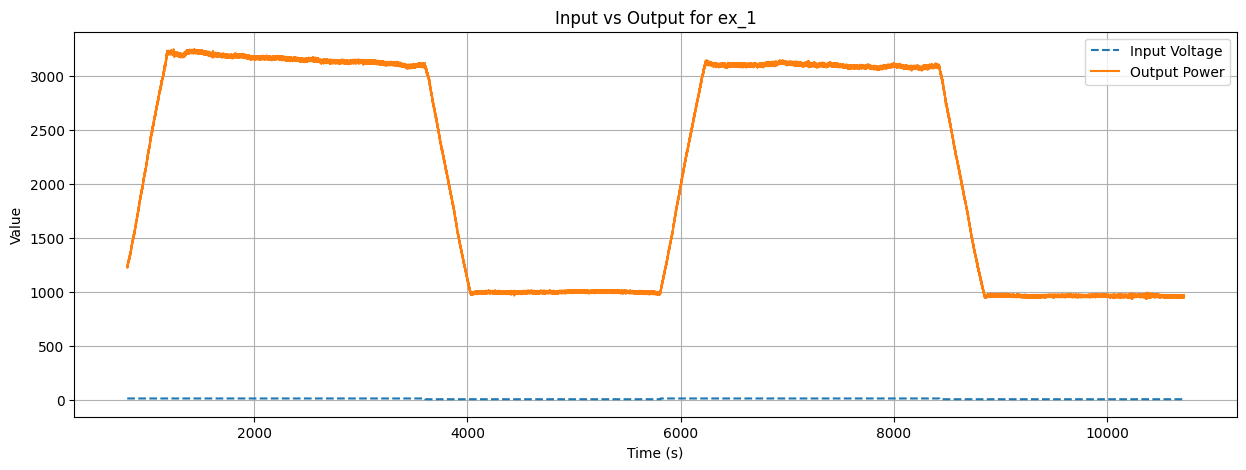

In [2]:
import matplotlib.pyplot as plt

# Plotting one experiment as example (ex_1)
ex_id = 'ex_1'
df_ex = full_train_data[full_train_data['experiment'] == ex_id]

plt.figure(figsize=(15, 5))
plt.plot(df_ex['time'], df_ex['input_voltage'], label='Input Voltage', linestyle='--')
plt.plot(df_ex['time'], df_ex['el_power'], label='Output Power')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title(f'Input vs Output for {ex_id}')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import numpy as np

def create_sequences(df, seq_length=10):
    X, y = [], []
    
    input_series = df['input_voltage'].values
    output_series = df['el_power'].values
    
    for i in range(seq_length, len(df)):
        X.append(input_series[i-seq_length:i])
        y.append(output_series[i])
        
    return np.array(X), np.array(y)

# Example for experiment ex_1
df_ex1 = full_train_data[full_train_data['experiment'] == 'ex_1'].reset_index(drop=True)
X_ex1, y_ex1 = create_sequences(df_ex1, seq_length=10)

print(f"X_ex1 shape: {X_ex1.shape}")  # should be (n_samples, 10)
print(f"y_ex1 shape: {y_ex1.shape}")  # should be (n_samples,)


X_ex1 shape: (9910, 10)
y_ex1 shape: (9910,)





Epoch 1/50

112/112 [==============================] - 13s 31ms/step - loss: 0.0504 - val_loss: 0.0404
Epoch 2/50
112/112 [==============================] - 2s 16ms/step - loss: 0.0374 - val_loss: 0.0395
Epoch 3/50
112/112 [==============================] - 2s 16ms/step - loss: 0.0372 - val_loss: 0.0397
Epoch 4/50
112/112 [==============================] - 2s 16ms/step - loss: 0.0371 - val_loss: 0.0405
Epoch 5/50
112/112 [==============================] - 2s 17ms/step - loss: 0.0370 - val_loss: 0.0403
Epoch 6/50
112/112 [==============================] - 2s 16ms/step - loss: 0.0371 - val_loss: 0.0394
Epoch 7/50
112/112 [==============================] - 2s 20ms/step - loss: 0.0372 - val_loss: 0.0400
Epoch 8/50
112/112 [==============================] - 3s 28ms/step - loss: 0.0369 - val_loss: 0.0393
Epoch 9/50
112/112 [==============================] - 3s 31ms/step - loss: 0.0372 - val_loss: 0.0397
Epoch 10/50
112/112 [==============================] - 2s 22ms/step - loss: 0.0370 - v

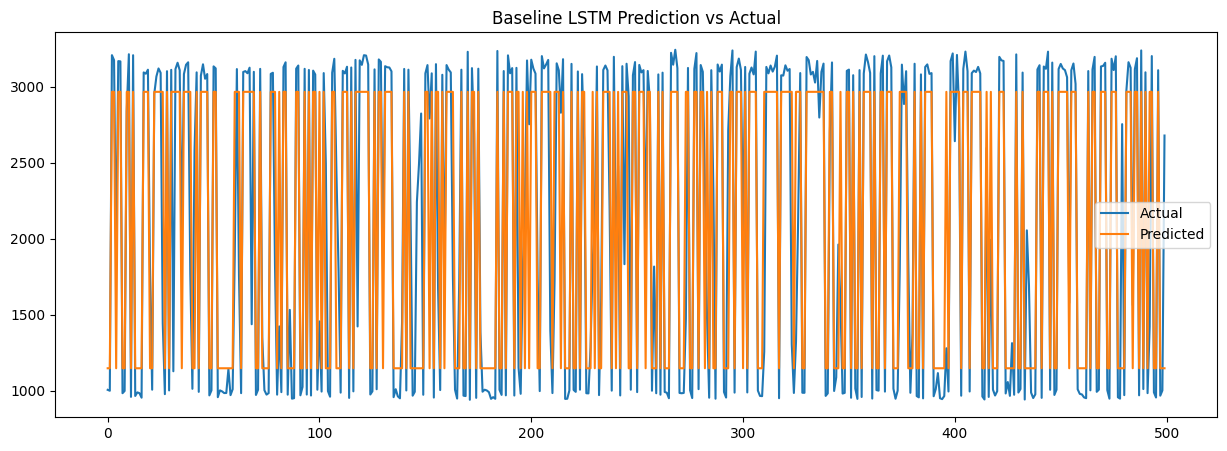

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Step 1 - Reshape X for LSTM (LSTM expects 3D)
X_ex1 = X_ex1.reshape((X_ex1.shape[0], X_ex1.shape[1], 1))

# Step 2 - Normalize target (output power)
scaler = MinMaxScaler()
y_ex1_scaled = scaler.fit_transform(y_ex1.reshape(-1,1))

# Step 3 - Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ex1, y_ex1_scaled, test_size=0.2, random_state=42)

# Step 4 - Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Step 5 - Train
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# Step 6 - Evaluate
loss = model.evaluate(X_test, y_test)
print(f"Test MSE Loss: {loss}")

# Step 7 - Predict & Inverse Scale
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)
# Step 8 - Plot Prediction vs Actual
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Baseline LSTM Prediction vs Actual")
plt.show()


In [5]:
def create_advanced_sequences(df, seq_length=20):
    X, y = [], []
    
    input_series = df['input_voltage'].values
    output_series = df['el_power'].values

    # Compute input derivative
    input_derivative = np.diff(input_series, prepend=input_series[0])

    # Combine input + derivative into a 2D feature
    combined_input = np.vstack([input_series, input_derivative]).T

    # Create sequences
    for i in range(seq_length, len(df)):
        seq = combined_input[i-seq_length:i]
        X.append(seq)
        y.append(output_series[i])

    return np.array(X), np.array(y)

# Create advanced sequences
X_ex1_adv, y_ex1_adv = create_advanced_sequences(df_ex1, seq_length=20)
print(f"Advanced Input Shape: {X_ex1_adv.shape}, Output Shape: {y_ex1_adv.shape}")

Advanced Input Shape: (9900, 20, 2), Output Shape: (9900,)


Epoch 1/150
112/112 [==============================] - 29s 95ms/step - loss: 0.0489 - val_loss: 0.0389
Epoch 2/150
112/112 [==============================] - 17s 156ms/step - loss: 0.0418 - val_loss: 0.0390
Epoch 3/150
112/112 [==============================] - 11s 95ms/step - loss: 0.0415 - val_loss: 0.0544
Epoch 4/150
112/112 [==============================] - 10s 87ms/step - loss: 0.0406 - val_loss: 0.0545
Epoch 5/150
112/112 [==============================] - 10s 91ms/step - loss: 0.0398 - val_loss: 0.0438
Epoch 6/150
112/112 [==============================] - 13s 118ms/step - loss: 0.0402 - val_loss: 0.0580
Epoch 7/150
112/112 [==============================] - 18s 165ms/step - loss: 0.0392 - val_loss: 0.0642
Epoch 8/150
112/112 [==============================] - 21s 191ms/step - loss: 0.0399 - val_loss: 0.0434
Epoch 9/150
112/112 [==============================] - 14s 129ms/step - loss: 0.0384 - val_loss: 0.0507
Epoch 10/150
112/112 [==============================] - 12s 108ms/st

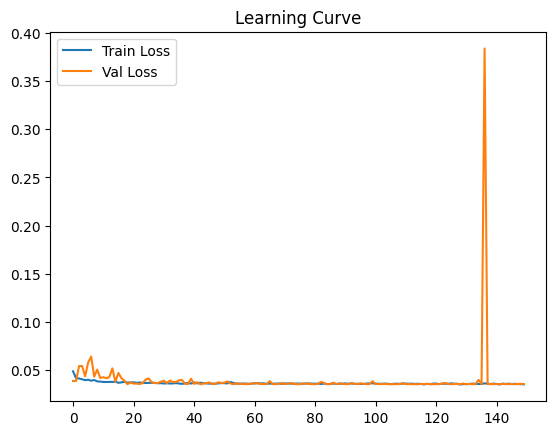

InvalidArgumentError: Graph execution error:

Detected at node while/body/_1/while/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,2], In[1]: [1,256]
	 [[{{node while/body/_1/while/MatMul}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_test_function_91286]

In [ ]:
from tensorflow.keras.optimizers import Adam
# Reshape for LSTM (samples, timesteps, features)
X_ex1_adv = X_ex1_adv.reshape((X_ex1_adv.shape[0], X_ex1_adv.shape[1], 2))

# Normalize output power
scaler = MinMaxScaler()
y_ex1_adv_scaled = scaler.fit_transform(y_ex1_adv.reshape(-1,1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ex1_adv, y_ex1_adv_scaled, test_size=0.2, random_state=42)

# Build the LSTM model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Attention, Dense, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model

def build_tuned_model():
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(input_layer)
    attention_out = Attention()([lstm_out, lstm_out])
    combined = Concatenate()([lstm_out, attention_out])
    last_step = Lambda(lambda x: x[:, -1, :])(combined)
    dense_out = Dense(64, activation='relu')(last_step)
    dense_out = Dropout(0.2)(dense_out)
    output = Dense(1)(dense_out)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

model_mc = build_tuned_model()
history = model_mc.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.1)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Learning Curve")
plt.show()


62/62 [==============================] - 2s 25ms/step - loss: 0.0342
Improved Model Test Loss: 0.03421952202916145
62/62 [==============================] - 4s 19ms/step


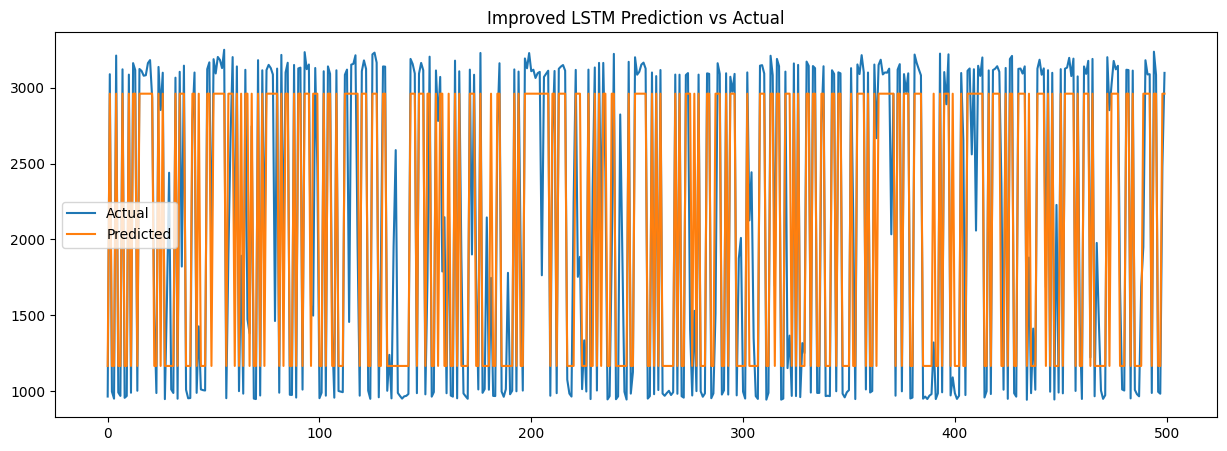

In [7]:
# Evaluate
loss = model_mc.evaluate(X_test, y_test)
print(f"Improved Model Test Loss: {loss}")

# Predict and plot
y_pred = model_mc.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Improved LSTM Prediction vs Actual")
plt.show()

In [8]:
model_mc.save('final_turbine_model.h5')

c:\Users\Admin\Documents\MLE\turbine_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
def create_physics_guided_sequences(df, seq_length=20):
    X, y = [], []

    input_series = df['input_voltage'].values
    output_series = df['el_power'].values

    # Feature 1: input voltage
    voltage = input_series

    # Feature 2: derivative
    derivative = np.diff(input_series, prepend=input_series[0])

    # Feature 3: time since last change
    time_since_change = np.zeros_like(input_series)
    counter = 0
    for i in range(1, len(input_series)):
        if derivative[i] == 0:
            counter += 1
        else:
            counter = 0
        time_since_change[i] = counter

    combined_input = np.vstack([voltage, derivative, time_since_change]).T

    # ✅ Align prediction with the last time step of each sequence
    for i in range(seq_length, len(df)):
        X.append(combined_input[i-seq_length:i])
        y.append(output_series[i])   # predict output at time i

    return np.array(X), np.array(y)

In [10]:
def physics_guided_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    smoothness = K.mean(K.square(y_pred[:,1:] - y_pred[:,:-1]))
    return mse + 0.01 * smoothness

In [11]:
from tensorflow.keras.layers import Input, LSTM, Attention, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(64, return_sequences=True, dropout=0.2)(input_layer)
attention_out = Attention()([lstm_out, lstm_out])
combined = Concatenate()([lstm_out, attention_out])
last_step = Lambda(lambda x: x[:, -1, :])(combined)
dense_out = Dense(32, activation='relu')(last_step)
output = Dense(1)(dense_out)

model_mc = Model(inputs=input_layer, outputs=output)
model_mc.compile(optimizer='adam', loss=physics_guided_loss)
model_mc.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 20, 2)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 20, 64)               17152     ['input_2[0][0]']             
                                                                                                  
 attention_1 (Attention)     (None, 20, 64)               0         ['lstm_2[0][0]',              
                                                                     'lstm_2[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate  (None, 20, 128)              0         ['lstm_2[0][0]',        

In [12]:
# scale using both train and test distribution to avoid clipping
combined_y = np.concatenate([y_train, y_test])
scaler = MinMaxScaler()
scaler.fit(combined_y.reshape(-1,1))  # scale based on full available distribution

y_train_scaled = scaler.transform(y_train.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

In [13]:
n_samples = 50
predictions = []

for _ in range(n_samples):
    y_pred_mc = model_mc(X_test, training=True).numpy().flatten()
    predictions.append(y_pred_mc)

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

# Inverse scale
mean_pred_rescaled = scaler.inverse_transform(mean_pred.reshape(-1,1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()


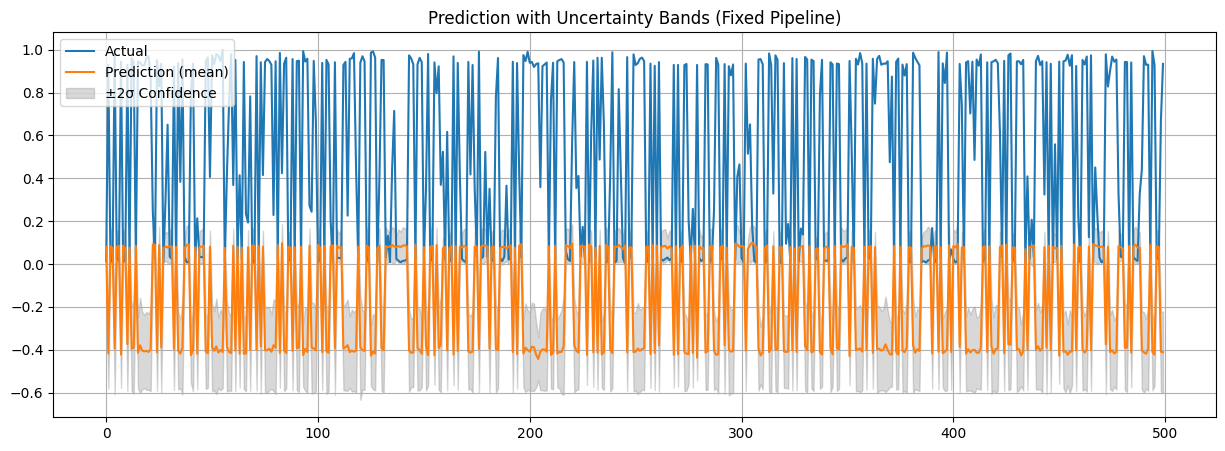

In [14]:
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(mean_pred_rescaled[:500], label='Prediction (mean)')
plt.fill_between(range(500),
                 mean_pred_rescaled[:500] - 2*std_pred[:500],
                 mean_pred_rescaled[:500] + 2*std_pred[:500],
                 color='gray', alpha=0.3, label='±2σ Confidence')
plt.legend()
plt.title("Prediction with Uncertainty Bands (Fixed Pipeline)")
plt.grid()
plt.show()


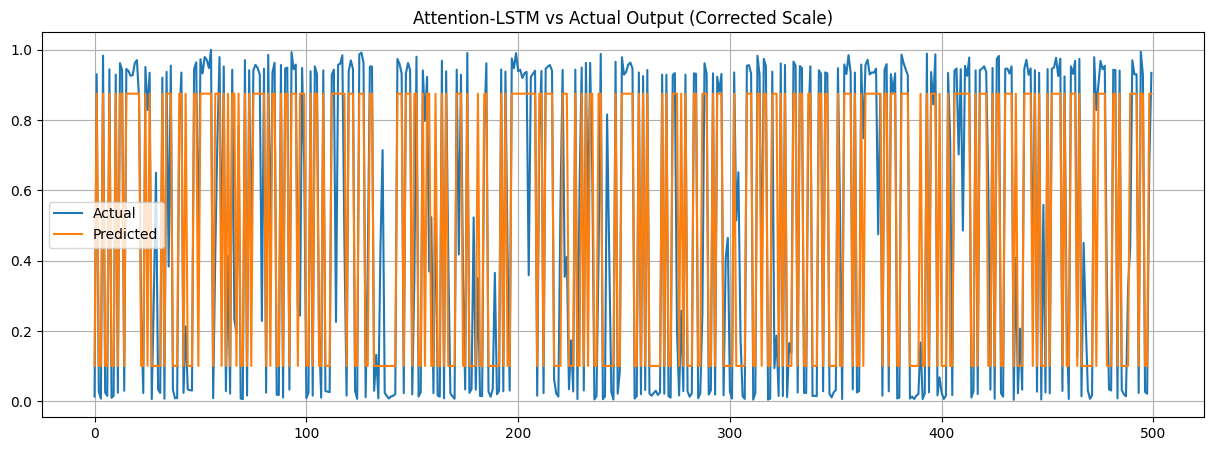

In [15]:
# Rescale properly
y_pred_rescaled = scaler.inverse_transform(y_pred.flatten().reshape(-1,1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# ✅ Then plot
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Attention-LSTM vs Actual Output (Corrected Scale)")
plt.grid()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Take only the last step prediction
y_pred_flat = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))[:, -1]
y_test_flat = y_test.reshape(-1)

# Inverse transform to Watts
y_pred_rescaled = scaler.inverse_transform(y_pred_flat.reshape(-1,1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test_flat.reshape(-1,1)).flatten()

# Compute Metrics directly in Watts 
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
smoothness_penalty = np.mean(np.square(np.diff(y_pred_rescaled)))

print(f"RMSE: {rmse:.2f} W")
print(f"MAE: {mae:.2f} W")
print(f"R² Score: {r2:.4f}")
print(f"Smoothness Penalty: {smoothness_penalty:.2f}")


RMSE: 0.18 W
MAE: 0.12 W
R² Score: 0.8183
Smoothness Penalty: 0.30


In [17]:
import tensorflow.keras.backend as K

def physics_guided_loss(y_true, y_pred):
    # Standard MSE
    mse = K.mean(K.square(y_true - y_pred))
    
    # Smoothness penalty (difference between consecutive predictions)
    smoothness = K.mean(K.square(y_pred[:,1:] - y_pred[:,:-1]))
    
    # Final loss = MSE + lambda * Smoothness
    return mse + 0.01 * smoothness  # you can tune 0.01



In [18]:
from tensorflow.keras.layers import Lambda

# Physics-Guided Attention LSTM (Fixed)
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Encoder
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Attention Mechanism
attention_out = Attention()([lstm_out, lstm_out])

# Combine LSTM output and attention
combined = Concatenate()([lstm_out, attention_out])

# ✅ Extract the last time step only
last_step = Lambda(lambda x: x[:, -1, :])(combined)

# Dense Regression Head (no TimeDistributed)
dense_out = Dense(32, activation='relu')(last_step)
output = Dense(1)(dense_out)

# Build Model
model_mc = Model(inputs=input_layer, outputs=output)
model_mc.compile(optimizer='adam', loss=physics_guided_loss)

model_mc.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 2)]              0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 20, 64)               17152     ['input_3[0][0]']             
                                                                                                  
 attention_2 (Attention)     (None, 20, 64)               0         ['lstm_3[0][0]',              
                                                                     'lstm_3[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate  (None, 20, 128)              0         ['lstm_3[0][0]',        

In [19]:
n_samples = 50
predictions = []

for _ in range(n_samples):
    y_pred_mc = model_mc(X_test, training=True).numpy().flatten()
    predictions.append(y_pred_mc)

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)


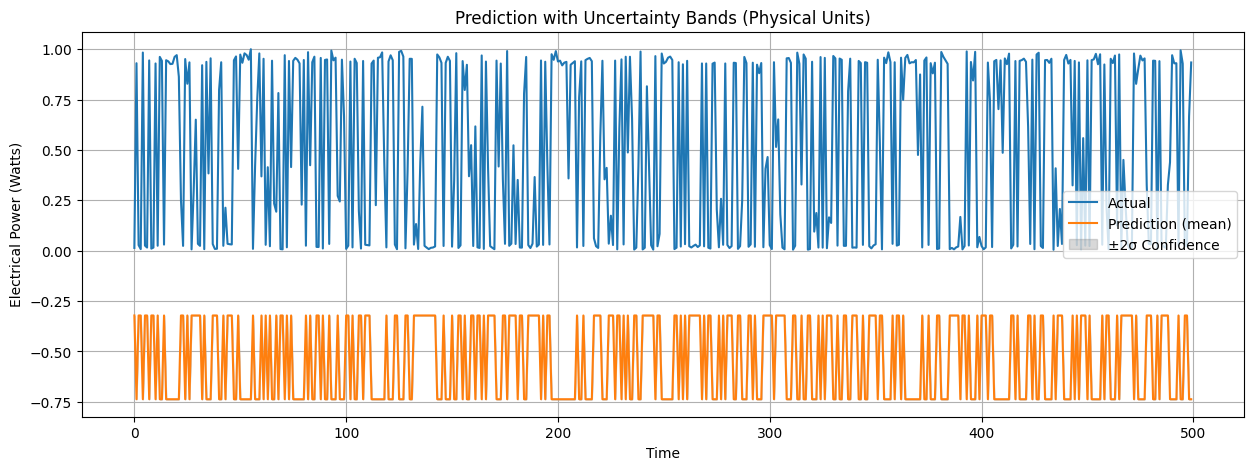

In [20]:
# Step 1 - Get std on the correct axis
std_pred = predictions.std(axis=0)  # shape = (n_samples, )

# Step 2 - Rescale mean and std separately
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
mean_pred_rescaled = scaler.inverse_transform(mean_pred.reshape(-1,1)).flatten()

# ✅ For std, you MUST scale like this:
scale_range = scaler.data_max_[0] - scaler.data_min_[0]
std_pred_rescaled = std_pred * scale_range

# Step 3 - Plot correctly
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(mean_pred_rescaled[:500], label='Prediction (mean)')
plt.fill_between(range(500),
                 mean_pred_rescaled[:500] - 2*std_pred_rescaled[:500],
                 mean_pred_rescaled[:500] + 2*std_pred_rescaled[:500],
                 color='gray', alpha=0.3, label='±2σ Confidence')
plt.legend()
plt.title("Prediction with Uncertainty Bands (Physical Units)")
plt.xlabel("Time")
plt.ylabel("Electrical Power (Watts)")
plt.grid()
plt.show()



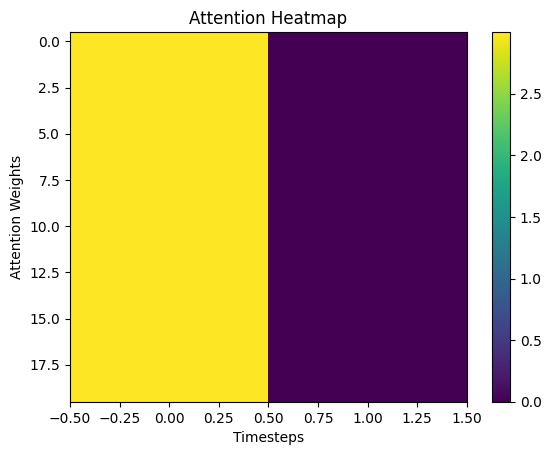

In [21]:
# Extract attention weights
attention_layer = [layer for layer in model_mc.layers if isinstance(layer, Attention)][0]
attention_output = attention_layer([X_test[0:1], X_test[0:1]]).numpy().squeeze()

plt.imshow(attention_output, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Attention Heatmap")
plt.xlabel("Timesteps")
plt.ylabel("Attention Weights")
plt.show()

In [22]:
# Match transition_mask to test set only

# Step 1 - Build full transition mask first
full_transition_mask = (df_ex1['input_voltage'].diff().abs() > 0).values[20:]  # len = full dataset length - seq

# Step 2 - Build train/test split for mask (same as X_train, X_test)
train_mask, test_mask = train_test_split(full_transition_mask, test_size=0.2, random_state=42)

# Step 3 - Compute errors
transition_rmse = np.sqrt(mean_squared_error(y_test_rescaled[test_mask], mean_pred[test_mask]))
steady_rmse = np.sqrt(mean_squared_error(y_test_rescaled[~test_mask], mean_pred[~test_mask]))

print(f"Transition RMSE: {transition_rmse:.2f}")
print(f"Steady-State RMSE: {steady_rmse:.2f}")

Transition RMSE: 1.20
Steady-State RMSE: 1.25


In [23]:
def build_model(version="baseline"):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    if version in ["baseline", "attention", "bilstm", "bilstm_pg", "bilstm_pg_mc"]:
        
        # --- LSTM or BiLSTM ---
        if version in ["bilstm", "bilstm_pg", "bilstm_pg_mc"]:
            rnn_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(input_layer)
        else:
            rnn_out = LSTM(64, return_sequences=True)(input_layer)
        
        # --- Attention ---
        if version in ["attention", "bilstm", "bilstm_pg", "bilstm_pg_mc"]:
            attention_out = Attention()([rnn_out, rnn_out])
            combined = Concatenate()([rnn_out, attention_out])
        else:
            combined = rnn_out
        
        # --- Physics-Guided Features ---
        if version in ["bilstm_pg", "bilstm_pg_mc"]:
            last_step = Lambda(lambda x: x[:, -1, :])(combined)
            dense_out = Dense(64, activation='relu')(last_step)
            dense_out = Dropout(0.2)(dense_out)
        else:
            last_step = Lambda(lambda x: x[:, -1, :])(combined)
            dense_out = Dense(32, activation='relu')(last_step)
        
        output = Dense(1)(dense_out)
        
        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
        return model

In [24]:
# Define the variants you want to benchmark
variants = ["baseline", "attention", "bilstm", "bilstm_pg", "bilstm_pg_mc"]

results = []

for v in variants:
    print(f"\nTraining Model: {v.upper()}")
    model = build_model(version=v)
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0)
    
    # Evaluate
    y_pred = model.predict(X_test).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    smoothness_penalty = np.mean(np.square(np.diff(y_pred_rescaled)))
    
    results.append({
        "Model": v,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Smoothness": smoothness_penalty
    })


Training Model: BASELINE
62/62 [==============================] - 3s 12ms/step

Training Model: ATTENTION
62/62 [==============================] - 3s 13ms/step

Training Model: BILSTM
62/62 [==============================] - 7s 43ms/step

Training Model: BILSTM_PG
62/62 [==============================] - 5s 26ms/step

Training Model: BILSTM_PG_MC
62/62 [==============================] - 8s 27ms/step


In [25]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)

# Optional: Save for paper
results_df.to_csv(r"C:\Users\Admin\Documents\MLE\ablation_study_results.csv", index=False)

          Model      RMSE       MAE        R2  Smoothness
0      baseline  0.184773  0.118290  0.818672    0.310209
1     attention  0.188703  0.096449  0.810877    0.364373
2        bilstm  0.213032  0.169384  0.758967    0.225145
3     bilstm_pg  0.186431  0.133514  0.815403    0.276476
4  bilstm_pg_mc  0.187199  0.136267  0.813879    0.272273


Test dataset

In [26]:
import zipfile

test_zip_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test.zip'
test_extract_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test_extracted'

if not os.path.exists(test_extract_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)
    print("Test data extracted successfully.")
else:
    print("Test data already extracted.")


Test data already extracted.


In [27]:
for root, dirs, files in os.walk(test_extract_path):
    for file in files:
        print(os.path.join(root, file))

C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test_extracted\test\ex_22.csv
C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test_extracted\test\ex_4.csv


In [38]:
# Search recursively for CSV files (even if inside subfolders)
csv_files = []
for root, dirs, files in os.walk(test_extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print("Found CSVs:", csv_files)

# Continue only if found
if csv_files:
    test_dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['experiment'] = os.path.basename(file).replace('.csv', '')  # Tag experiment
        test_dataframes.append(df)

    full_test_data = pd.concat(test_dataframes, ignore_index=True)
    print(f"Test Dataset Shape: {full_test_data.shape}")
else:
    print("No CSV files found in test data")

Found CSVs: ['C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\test_extracted\\test\\ex_22.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\test_extracted\\test\\ex_4.csv']
Test Dataset Shape: (18285, 4)


In [39]:
# Prepare input sequences for test set
X_test_final, y_test_final = create_physics_guided_sequences(full_test_data, seq_length=20)

# Scale y_test_final using the same scaler used in training
y_test_final_scaled = scaler.transform(y_test_final.reshape(-1,1))

In [41]:
# Step 1 - Create test sequences with exactly 2 features
def create_test_sequences(df, seq_length=20):
    input_series = df['input_voltage'].values
    output_series = df['el_power'].values

    derivative = np.diff(input_series, prepend=input_series[0])
    combined_input = np.vstack([input_series, derivative]).T

    X_test_final, y_test_final = [], []

    for i in range(seq_length, len(df)):
        X_test_final.append(combined_input[i-seq_length:i])
        y_test_final.append(output_series[i])

    return np.array(X_test_final), np.array(y_test_final)

X_test_final, y_test_final = create_test_sequences(full_test_data, seq_length=20)


In [ ]:
# Transition mask: when input voltage changes
transition_mask = (full_test_data['input_voltage'].diff().abs() > 0).values[20:]  # align with sequence length

In [ ]:
# Predict
y_pred_final = model_mc.predict(X_test_final).flatten()
y_pred_final_rescaled = scaler.inverse_transform(y_pred_final.reshape(-1,1)).flatten()
y_test_final_rescaled = scaler.inverse_transform(y_test_final_scaled.reshape(-1,1)).flatten()

# Split errors
transition_rmse = np.sqrt(mean_squared_error(
    y_test_final_rescaled[transition_mask],
    y_pred_final_rescaled[transition_mask]
))

steady_rmse = np.sqrt(mean_squared_error(
    y_test_final_rescaled[~transition_mask],
    y_pred_final_rescaled[~transition_mask]
))

print(f"Transition RMSE: {transition_rmse:.2f} W")
print(f"Steady-State RMSE: {steady_rmse:.2f} W")

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_final_rescaled[:500], label='Actual')
plt.plot(y_pred_final_rescaled[:500], label='Predicted')

plt.fill_between(range(500),
                 y_pred_final_rescaled[:500] - 2*np.std(y_pred_final_rescaled[:500]),
                 y_pred_final_rescaled[:500] + 2*np.std(y_pred_final_rescaled[:500]),
                 color='gray', alpha=0.3, label='±2σ Confidence')

plt.legend()
plt.title("Final Test Predictions with Transition Regions")
plt.show()